# Perturbation Experiments
This notebook creates perturbations of existing networks and features and writes them back as separate containers. Those can be trained afterwards.
We define a network perturbation as swapping a certain percentage of edges in the network. Similarly, we define feature perturbations as exchanging node features of two nodes.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import h5py, os, sys
import random

sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Load some data for perturbation

In [2]:
input_data_path = '../data/pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5'
network_name = 'CPDB'
data = gcnIO.load_hdf_data(input_data_path, feature_name='features')
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data
print("Read data from: {}".format(input_data_path))

Read data from: ../data/pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5


## Network Perturbations
We start by perturbing the underlying PPI networks to various degrees. We do so using the networkx package.

In [3]:
adj_names = pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(adj_names)
print (nx.algorithms.connected.is_connected(G))

False


In [14]:
def _single_edge_swap(G, swapped_edges):
    edges = [x for x in G.edges if not x in swapped_edges]
    success = False
    while not success and len(edges) >= 2:
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        if not edge1 == edge2:
            success = True
            G.add_edge(edge1[0], edge2[0])
            G.add_edge(edge1[1], edge2[1])
            G.remove_edge(*edge1)
            G.remove_edge(*edge2)
            swapped_edges.append(edge1)
            swapped_edges.append(edge2)
    return G, swapped_edges

def swap_edges_exact(G, percentage):
    H = G.copy()
    #n_swaps = int(G.number_of_edges() * percentage)
    n_swaps = 10
    print (n_swaps)
    performed_swaps = 0
    swapped_edges = []
    while not performed_swaps >= n_swaps:
        success = False
        while not success:
            H_new = nx.double_edge_swap(H.copy(), nswap=1, max_tries=10)
            swapped = nx.difference(H, H_new).edges
            if not swapped in swapped_edges:
                success = True
                H = H_new
        print ("swap done")
        performed_swaps += 2
    #swaps = nx.double_edge_swap(H, nswap=n_swaps//2, max_tries=n_swaps*10)
    print ("Tried {0} swaps and succeeded with {1}".format(n_swaps, nx.difference(G, H).number_of_edges()))
    return H, nx.difference(G, H).number_of_edges()


def swap_edges(G, percentage):
    H = G.copy()
    n_swaps = int(G.number_of_edges() * percentage)
    swaps = nx.double_edge_swap(H, nswap=n_swaps//2, max_tries=n_swaps*100)
    print ("Tried {0} swaps and succeeded with {1}".format(n_swaps, nx.difference(G, H).number_of_edges()))
    return H, nx.difference(G, H).number_of_edges()

# the API for swaps in nx is annoying so I had to try out
# different numbers of attempts to roughly get n percent of
# the edges swapped. This is ugly but works at least.
# roughly corresponds to 0, 0.25, 0.5 and 0.75 (because not every swap works)
swapping_percentages = [0, 0.29, 0.7, 1.48, 10]
perturbed_networks = [G]
for percentages in swapping_percentages[1:]:
    perturbation, n_success = swap_edges(G, percentages)
    perturbed_networks.append(perturbation)
    print ("Created network with {0:.2f}% swapped edges".format((n_success/G.number_of_edges())*100))
swapping_percentages = [0, 0.25, 0.5, 0.75, 1]

Tried 73134 swaps and succeeded with 63217
Created network with 25.07% swapped edges
Tried 176532 swaps and succeeded with 125553
Created network with 49.79% swapped edges
Tried 373239 swaps and succeeded with 189651
Created network with 75.20% swapped edges
Tried 2521890 swaps and succeeded with 241225
Created network with 95.65% swapped edges


In [16]:
rand_degree_graph = nx.generators.expected_degree_graph(w=[i[1] for i in G.degree], selfloops=False)
_ = nx.relabel_nodes(rand_degree_graph, pd.DataFrame(node_names).to_dict()[1], copy=False) # they should have the node names
swapping_percentages.append('Random_degreepreserved')
perturbed_networks.append(rand_degree_graph)

In [17]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes_shuffled = nodes.sample(frac=1)
nodes_shuffled.index = np.arange(nodes.shape[0])
rand_power_graph = nx.generators.powerlaw_cluster_graph(n=int(G.number_of_nodes()), m=int(G.number_of_edges()/G.number_of_nodes()), p=0.1)
_ = nx.relabel_nodes(rand_power_graph, nodes_shuffled.to_dict()['Name'], copy=False) # they should have the node names
swapping_percentages.append('Random_powerlaw')
perturbed_networks.append(rand_power_graph)
nx.algorithms.components.is_connected(rand_power_graph)

True

<AxesSubplot:xlabel='Cancer_Gene', ylabel='Degree'>

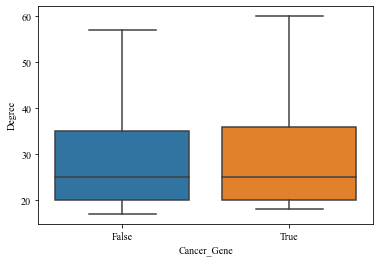

In [18]:
cancer_genes = node_names[np.logical_or(np.logical_or(y_train.reshape(-1), y_val.reshape(-1)), y_test.reshape(-1)), 1]
degrees = pd.DataFrame(pd.Series({node: degree for (node, degree) in rand_power_graph.degree()}, name='Degree'))
degrees['Cancer_Gene'] = False
degrees.loc[degrees.index.isin(cancer_genes), 'Cancer_Gene'] = True
sns.boxplot(data=degrees, x='Cancer_Gene', y='Degree', showfliers=False)

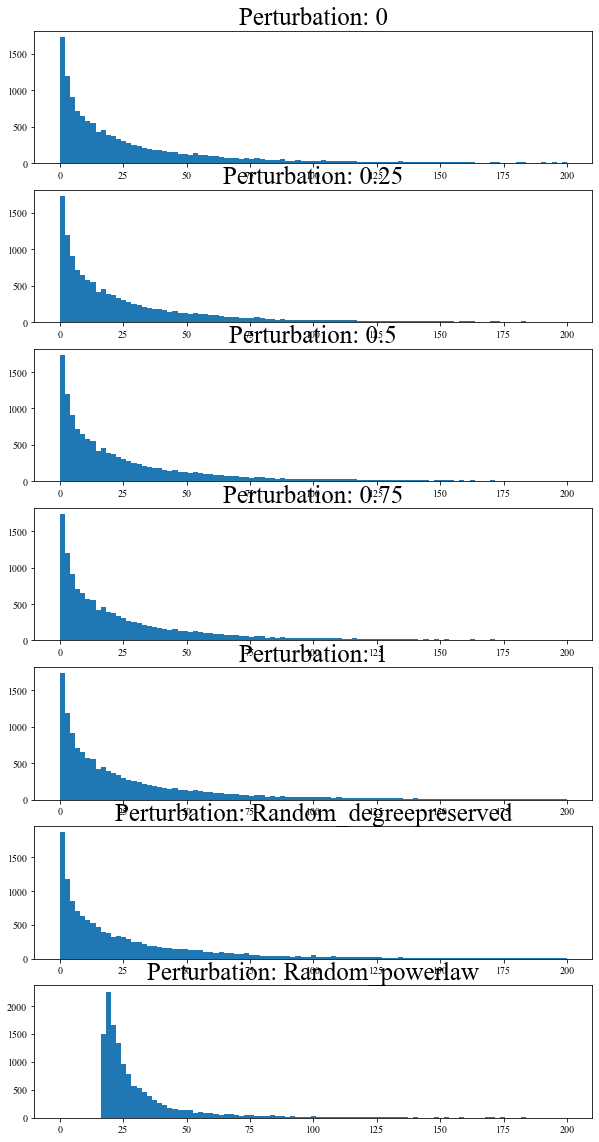

In [19]:
fig = plt.figure(figsize=(10, 20))
bins = np.linspace(0, 200, 100)

for i in range(len(swapping_percentages)):
    plt.subplot(len(swapping_percentages), 1, i+1)
    _ = plt.hist([v for k, v in perturbed_networks[i].degree()], bins)
    plt.title("Perturbation: {}".format(swapping_percentages[i]), size=25)

In [20]:
for i in range(len(swapping_percentages)):
    print ("Graph {} is {}".format(swapping_percentages[i], 'connected' if nx.algorithms.connected.is_connected(perturbed_networks[i]) else 'not connected'))

Graph 0 is not connected
Graph 0.25 is not connected
Graph 0.5 is not connected
Graph 0.75 is not connected
Graph 1 is connected
Graph Random_degreepreserved is not connected
Graph Random_powerlaw is connected


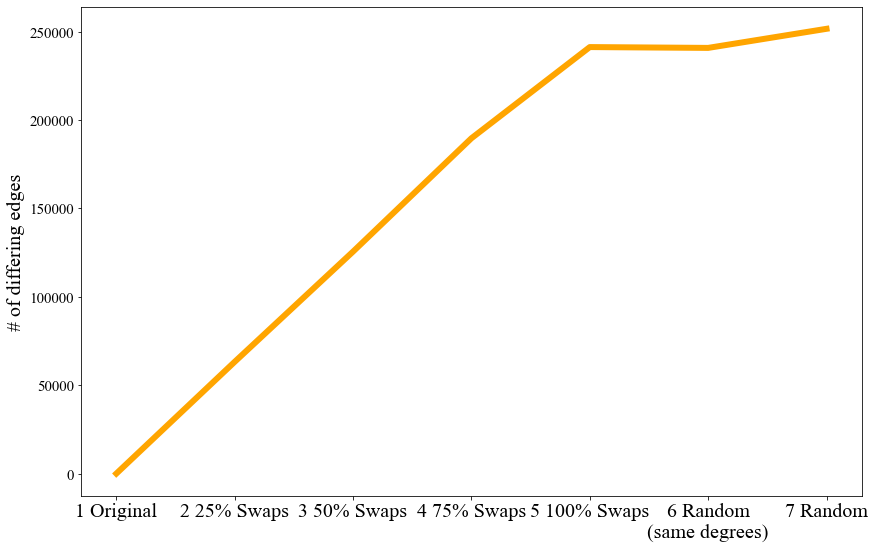

In [23]:
def _get_number_of_different_edges(original, perturbed):
    edges_removed_from_original = 0
    for edge in original.edges():
        if not perturbed.has_edge(*edge):
            edges_removed_from_original += 1
    return edges_removed_from_original

num_diff_edges = []
for Q in perturbed_networks:
    num_diff_edges.append(nx.difference(G, Q).number_of_edges())

fig = plt.figure(figsize=(14, 9))
sns.lineplot(x=['1 Original', '2 25% Swaps', '3 50% Swaps', '4 75% Swaps', '5 100% Swaps', '6 Random\n(same degrees)', '7 Random'], y=num_diff_edges, lw=6, color='orange', ms=20)
plt.ylabel('# of differing edges', size=20)
_ = plt.xticks(size=20)
_ = plt.yticks(size=15)
#_ = plt.gca().set_xticklabels(labels=['Original', '50% Swaps', '100% Swaps', 'Random'])

### Write network perturbations back to HDF5

In [24]:
def write_hdf5_container(fname, A, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=A, shape=A.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

In [25]:
perturbation_folder = '/project/gcn/diseasegcn/data/network_perturbation_{}_rev1/'.format(network_name)

if not os.path.isdir(perturbation_folder):
    os.mkdir(perturbation_folder)
else:
    for file in os.listdir(perturbation_folder):
        os.remove(os.path.join(perturbation_folder, file))

for i in range(len(swapping_percentages)):
    fname = os.path.join(perturbation_folder, '{}_{}_perturbation.h5'.format(network_name, str(swapping_percentages[i]).replace('.', '_')))
    write_hdf5_container(fname, nx.to_pandas_adjacency(perturbed_networks[i], nodelist=node_names[:, 1]), features, node_names,
                         y_train, y_val, y_test,
                         train_mask, val_mask, test_mask,
                         feature_names, features
                        )

Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_0_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_0_25_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_0_5_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_0_75_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_1_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_Random_degreepreserved_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation_CPDB_rev1/CPDB_Random_powerlaw_perturbation.h5


In [26]:
G_test = nx.to_pandas_adjacency(perturbed_networks[i], nodelist=node_names[:, 1])
(G_test.index == node_names[:, 1]).all()

True

In [27]:
G_test.shape

(13627, 13627)

## Feature Perturbations
Next, we also want to shuffle around the features to investigate how much learning can happen if the structure in the features is lost gradually.

In [28]:
def _swap_row(matrix, idx_from, idx_to):
    tmp = matrix[idx_from]
    matrix[idx_from] = matrix[idx_to]
    matrix[idx_to] = tmp
"""
def perturb_features(features, percentage, max_tries=100):
    n_swaps = percentage * features.shape[0]
    print (n_swaps)
    available_nodes = list(np.arange(features.shape[0]))
    for swap in range(int(n_swaps)):
        found_new_swap = False
        num_tries = 0
        while not found_new_swap or num_tries < max_tries:
            fro, to = np.random.randint(features.shape[0], size=2)
            if not fro in already_perturbed and not to in already_perturbed:
                found_new_swap = True
                _swap_row(features, fro, to)
                already_perturbed.append(fro)
                already_perturbed.append(to)
            else:
                num_tries += 1
    print (len(already_perturbed))
    return features, already_perturbed
"""

def perturb_features(features, percentage, max_tries=100):
    n_swaps = percentage * features.shape[0]
    available_nodes = list(np.arange(features.shape[0]))
    for swap in range(int(n_swaps)):
        fro = random.choice(available_nodes)
        available_nodes.remove(fro)
        to = random.choice(np.arange(features.shape[0]))
        _swap_row(features, fro, to)
    return features


perturbed_features = [features]
for percentages in swapping_percentages[1:]:
    if type(percentages) == float or type(percentages) == int:
        perturbed_features.append(perturb_features(features.copy(), percentages))
        print ("Swapped {}% of the features".format(percentages*100))
    else:
        perturbed_features.append(np.random.randn(features.shape[0], 1))
        #perturbed_features.append(np.random.randn(*features.shape))
        print ("Created random features")


Swapped 25.0% of the features
Swapped 50.0% of the features
Swapped 75.0% of the features
Swapped 100% of the features
Created random features
Created random features


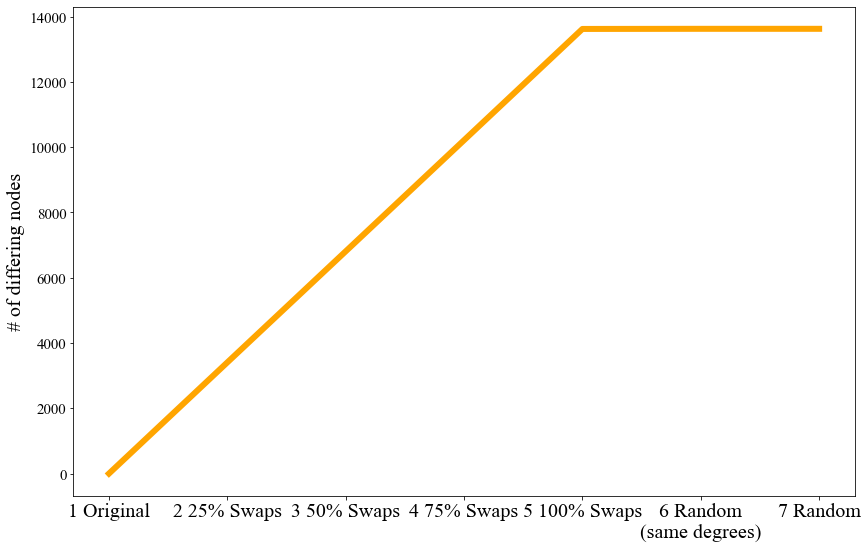

In [30]:
num_diff_rows = []
for F in perturbed_features:
    num_diff_rows.append( F.shape[0] - (F == features).all(axis=1).sum() )

fig = plt.figure(figsize=(14, 9))
sns.lineplot(x=['1 Original', '2 25% Swaps', '3 50% Swaps', '4 75% Swaps', '5 100% Swaps', '6 Random\n(same degrees)', '7 Random'],
             y=num_diff_rows, lw=6, color='orange', ms=20)
plt.ylabel('# of differing nodes', size=20)
_ = plt.xticks(size=20)
_ = plt.yticks(size=15)
#_ = plt.gca().set_xticklabels(labels=['Original', '50% Swaps', '100% Swaps'])

In [31]:
y_train.sum(), y_test.sum(), y_val.sum()

(537, 199, 60)

In [16]:
all_deg_dfs = []
for p in range(len(swapping_percentages)):
    # compute node degrees from the network
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    degrees = nx.to_pandas_adjacency(G=perturbed_networks[p], nodelist=nodes.Name).sum(axis=0)
    assert ((degrees.index == nodes.Name).all())
    nodes['Degree'] = np.array(degrees) # same ordering as the node names
    
    # compute the label information
    y_pos = np.logical_or(np.logical_or(y_train, y_test), y_val).reshape(-1)
    y_neg = np.logical_and(np.logical_or(np.logical_or(train_mask, test_mask), val_mask), np.logical_not(y_pos).reshape(-1))
    print (y_pos.shape, y_neg.shape)
    nodes['Label'] = 'unknown'
    nodes.loc[y_pos, 'Label'] = 'Cancer Gene'
    nodes.loc[y_neg, 'Label'] = 'Non Cancer Gene'
    nodes['Network'] = str(swapping_percentages[p])
    
    # compute betweenness centrality
    if nx.algorithms.connected.is_connected(perturbed_networks[p]):
        betweenness = nx.algorithms.centrality.approximate_current_flow_betweenness_centrality(G=perturbed_networks[p])
        betweenness_df = pd.DataFrame.from_dict({key: [betweenness[key]] for key in betweenness}).T
        betweenness_df.columns = ['Betweenness']
        all_measures = nodes.join(betweenness_df, on='Name')
    else:
        nodes['Betweenness'] = np.nan
        all_measures = nodes
    
    print ("Computed measures for perturbed network: {}".format(p))
    all_deg_dfs.append(all_measures)

(13627,) (13627,)
Computed measures for perturbed network: 0
(13627,) (13627,)
Computed measures for perturbed network: 1


KeyboardInterrupt: 

In [22]:
y_train.sum(), y_test.sum(), y_val.sum()

(537, 199, 60)

In [32]:
fig = plt.figure(figsize=(15, 10))
all_degs = pd.concat(all_deg_dfs)
sns.boxplot(data=all_degs, x='Network', y='Degree', hue='Label')
plt.legend(fontsize=25)
#plt.ylim([-0.0003, 0.01])
#plt.ylim([-5, 400])

NameError: name 'all_deg_dfs' is not defined

<Figure size 1080x720 with 0 Axes>

### Write feature perturbations back to HDF5

In [33]:
perturbation_folder = '/project/gcn/diseasegcn/data/feature_perturbation_{}_rev1_v3/'.format(network_name)

if not os.path.isdir(perturbation_folder):
    os.mkdir(perturbation_folder)
else:
    for file in os.listdir(perturbation_folder):
        os.remove(os.path.join(perturbation_folder, file))

for i in range(len(swapping_percentages)):
    fname = os.path.join(perturbation_folder, '{}_{}_feature_perturbation.h5'.format(network_name, str(swapping_percentages[i]).replace('.', '_')))
    write_hdf5_container(fname, adj, perturbed_features[i], node_names,
                         y_train, y_val, y_test,
                         train_mask, val_mask, test_mask,
                         feature_names, perturbed_features[i]
                        )

Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_0_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_0_25_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_0_5_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_0_75_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_1_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_Random_degreepreserved_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation_CPDB_rev1_v3/CPDB_Random_powerlaw_feature_perturbation.h5


## Perturb both, network and features

In [34]:
# can just use the already perturbed networks/features and make containers with their combinations...
perturbation_folder = '/project/gcn/diseasegcn/data/netfeat_perturbation_{}_rev1_v2/'.format(network_name)

if not os.path.isdir(perturbation_folder):
    os.mkdir(perturbation_folder)
else:
    for file in os.listdir(perturbation_folder):
        os.remove(os.path.join(perturbation_folder, file))

for i in range(len(swapping_percentages)):
    fname = os.path.join(perturbation_folder,
                         '{}_{}_networkfeature_perturbation.h5'.format(network_name, str(swapping_percentages[i]).replace('.', '_'))
                        )
    write_hdf5_container(fname, nx.to_pandas_adjacency(perturbed_networks[i], nodelist=node_names[:, 1]),
                         perturbed_features[i], node_names,
                         y_train, y_val, y_test,
                         train_mask, val_mask, test_mask,
                         feature_names, perturbed_features[i]
                        )

Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_0_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_0_25_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_0_5_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_0_75_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_1_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_Random_degreepreserved_networkfeature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/netfeat_perturbation_CPDB_rev1_v2/CPDB_Random_powerlaw_networkfeature_perturbation.h5
